In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import sqrt

import data
import phi

In [3]:
# Collect the data from each of the sources
sparcGalaxies = data.GetGalaxyData("data/Sparc/Rotmod_LTG/")
xueSofueGalaxies = data.GetGalaxyData("data/XueSofue/")

In [4]:
# Get the galaxies we want from each source
NGC5371 = np.array(sparcGalaxies['NGC5371_rotmod'])
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

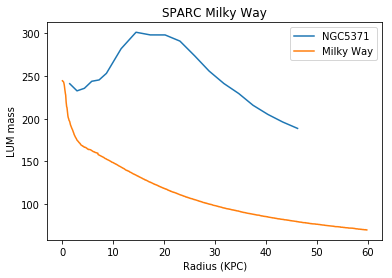

In [5]:
# Plot both galaxies side by side
NGC5371_rad = NGC5371[:,0]
NGC5371_gas = NGC5371[:,3]
NGC5371_disk = NGC5371[:,4]
NGC5371_bulge = NGC5371[:,5]

NGC5371_lum = np.sqrt(NGC5371_gas*NGC5371_gas + NGC5371_disk*NGC5371_disk + NGC5371_bulge*NGC5371_bulge)

kpc_MW = MWXueSofue[:,0]
vobs_MW = MWXueSofue[:,1]
plt.plot(NGC5371_rad, NGC5371_lum, kpc_MW, vobs_MW)
plt.legend(['NGC5371', 'Milky Way', 'cubic'], loc='best')
plt.xlabel('Radius (KPC)')
plt.ylabel('LUM mass')
plt.title('SPARC Milky Way')
plt.show()

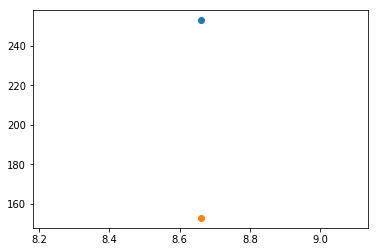

In [6]:
# Interpolation Test
mw_function = interp1d(kpc_MW, vobs_MW, kind='cubic')

NG_rad = NGC5371_rad[5]
NG_y = NGC5371_lum[5]

plt.plot(NG_rad, NG_y, 'o', NG_rad, mw_function(NG_rad), 'o')
plt.show()

# We Now have the interpolators! #
This allows us to get milky way values at any radius! 
Now we get phi for the other galaxy, then get phi for the Milky Way with the same radii as the other galaxy.

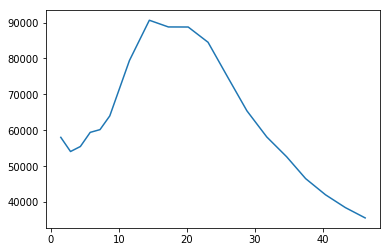

In [7]:
# Calculate vSquared for other galaxy
NGC_vSquared = NGC5371_gas*NGC5371_gas + NGC5371_disk*NGC5371_disk + NGC5371_bulge*NGC5371_bulge
# Plot our function of r -> vSquared
plt.plot(NGC5371_rad, NGC_vSquared)
plt.show()

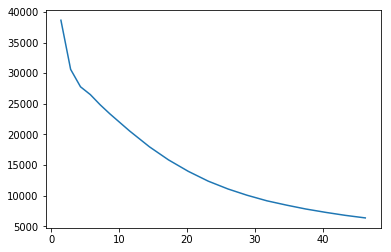

In [8]:
# Calculate vSquared for MW with other galaxies radii
MW_v = [mw_function(r) for r in NGC5371_rad]
MW_vSquared = [r ** 2 for r in MW_v]
# Plot our function of r -> vSquared
plt.plot(NGC5371_rad, MW_vSquared)
plt.show()

In [9]:
# Calculate Phi for each galaxy
NGC_phi = phi.CalcWithRadiiAndVSquared(NGC5371_rad, NGC_vSquared)
MW_phi = phi.CalcWithRadiiAndVSquared(NGC5371_rad, MW_vSquared)

/Users/Zac/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


## Here is Phi for the Milky Way and the other galaxy and##
We used the interpolator to get v at the same points as the other galaxy, then ran each galaxy through phi.CalcWithRadiiAndVSquared to get phi!

/Users/Zac/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


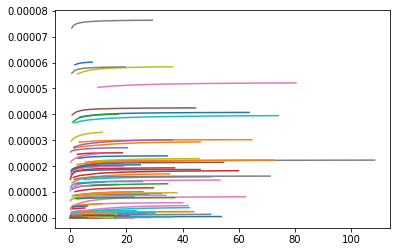

In [19]:
f, ax = plt.subplots(1)
ax.plot(NGC5371_rad, MW_phi)

for galaxyName in sparcGalaxies:
    galaxy = np.array(sparcGalaxies[galaxyName])
    radii = galaxy[:,0]
    gas = galaxy[:,3]
    disk = galaxy[:,4]
    bulge = galaxy[:,5]
    vSquared = gas*gas + disk*disk + bulge*bulge
    galaxyPhi = phi.CalcWithRadiiAndVSquared(radii, vSquared)
    ax.plot(radii, galaxyPhi)